# Introduction

In this notebook, adapted from UniLM's run_funsd script, itself adapted from HuggingFace's run_ner script, we are going to fine-tune the LayoutLMv2 model by Microsoft Research on the CORD dataset, which is a collection of receipts with OCR annotations. The dataset defines 30 fields under different categories ("menu", "subtotal", "total") and the task aims to label each word to the right field. The evaluation metric is entity-level F1. The notebook requires [unilm/layoutlmft](https://github.com/microsoft/unilm/tree/master/layoutlmft) to be installed.

In [64]:
import numpy as np

from datasets import load_dataset, load_metric
from pprint import pprint

from layoutlmft.trainers import FunsdTrainer as Trainer

In [133]:
# to disable CUDA
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=


# Load dataset

In [134]:
datasets = load_dataset("cord.py", data_dir="../data/CORD")

Using custom data configuration default-data_dir=..%2Fdata%2FCORD
Reusing dataset cord (/home/pierre/.cache/huggingface/datasets/cord/default-data_dir=..%2Fdata%2FCORD/0.0.0/adfa6c1aaded7fc9e4ede12c124e5e98a3b6254a7dfe65798c3d6518973b3502)


In [135]:
datasets["test"]

Dataset({
    features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
    num_rows: 100
})

In [136]:
column_names = datasets["train"].column_names
features = datasets["train"].features
text_column_name = "tokens"
label_column_name = "ner_tags"
remove_columns = column_names
label_list = features[label_column_name].feature.names
label_to_id = {i: i for i in range(len(label_list))}
num_labels = len(label_list)


# Load model and tokenizer

In [137]:
from transformers import (
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
    TrainingArguments,
)

In [138]:
# model_name = "microsoft/layoutlmv2-base-uncased"
model_name = "../output/v2_local_cpu/"

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="ner",
    # cache_dir=model_args.cache_dir,
    # revision=model_args.model_revision,
    # use_auth_token=True if model_args.use_auth_token else None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    # cache_dir=model_args.cache_dir,
    use_fast=True,
    # revision=model_args.model_revision,
    # use_auth_token=True if model_args.use_auth_token else None,
)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    config=config,
    # cache_dir=model_args.cache_dir,
    # revision=model_args.model_revision,
    # use_auth_token=True if model_args.use_auth_token else None,
)



# Preprocess dataset

In [187]:
# Padding strategy
padding = "max_length"#False
# Tokenize all texts and align the labels with them.
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples[text_column_name],
        padding=padding,
        truncation=True,
        return_overflowing_tokens=True,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )

    labels = []
    bboxes = []
    images = []
    for batch_index in range(len(tokenized_inputs["input_ids"])):
        word_ids = tokenized_inputs.word_ids(batch_index=batch_index)
        org_batch_index = tokenized_inputs["overflow_to_sample_mapping"][batch_index]

        label = examples[label_column_name][org_batch_index]
        bbox = examples["bboxes"][org_batch_index]
        image = examples["image"][org_batch_index]
        previous_word_idx = None
        label_ids = []
        bbox_inputs = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
                bbox_inputs.append([0, 0, 0, 0])
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
                bbox_inputs.append(bbox[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(-100)
                bbox_inputs.append(bbox[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
        bboxes.append(bbox_inputs)
        images.append(image)
    tokenized_inputs["labels"] = labels
    tokenized_inputs["bbox"] = bboxes
    tokenized_inputs["image"] = images
    return tokenized_inputs

train_dataset = datasets["train"]
train_dataset = train_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=remove_columns,
    num_proc=4,
    load_from_cache_file=True,
)

eval_dataset = datasets["validation"]
eval_dataset = eval_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=remove_columns,
    num_proc=4,
    load_from_cache_file=True,
)

test_dataset = datasets["test"]
test_dataset = test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=remove_columns,
    num_proc=4,
    load_from_cache_file=True,
)

#0:   0%|          | 0/1 [00:00<?, ?ba/s]


#0: 100%|██████████| 1/1 [00:06<00:00,  6.98s/ba]

#1: 100%|██████████| 1/1 [00:08<00:00,  8.01s/ba]


#0:   0%|          | 0/1 [00:00<?, ?ba/s]


#0: 100%|██████████| 1/1 [00:00<00:00,  2.46ba/s]



#0:   0%|          | 0/1 [00:00<?, ?ba/s]


#1: 100%|██████████| 1/1 [00:00<00:00,  2.87ba/s]

#2: 100%|██████████| 1/1 [00:00<00:00,  2.85ba/s]


#3: 100%|██████████| 1/1 [00:00<00:00,  3.19ba/s]


# Metrics and Trainer

In [9]:
from layoutlmft.data import DataCollatorForKeyValueExtraction

In [12]:
# Data collator
data_collator = DataCollatorForKeyValueExtraction(
    tokenizer,
    pad_to_multiple_of=8,
    padding=padding,
    max_length=512,
)

# Metrics
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if False:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

# Initialize our Trainer
training_args = TrainingArguments(output_dir=".", per_device_train_batch_size=1, evaluation_strategy="steps")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


# Training

In [11]:
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload

metrics["train_samples"] = len(train_dataset)

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

 21%|██        | 500/2400 [47:36<4:15:41,  8.07s/it]

{'loss': 2.3145, 'learning_rate': 3.958333333333333e-05, 'epoch': 0.62}


 42%|████▏     | 1000/2400 [1:46:25<3:35:52,  9.25s/it]

{'loss': 1.0954, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}


 62%|██████▎   | 1500/2400 [2:39:44<1:16:39,  5.11s/it]

{'loss': 0.6397, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.88}


 83%|████████▎ | 2000/2400 [3:26:02<35:23,  5.31s/it]

{'loss': 0.4688, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


100%|██████████| 2400/2400 [4:03:44<00:00,  6.09s/it]


{'train_runtime': 14624.3808, 'train_samples_per_second': 0.164, 'epoch': 3.0}


# Evaluation

In [12]:
metrics = trainer.evaluate()

metrics["eval_samples"] = len(eval_dataset)

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 13/13 [02:32<00:00, 10.48s/it]/opt/virtualenv/layoutlmft/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 13/13 [02:32<00:00, 11.76s/it]


In [13]:
metrics

{'eval_loss': 0.404183566570282,
 'eval_precision': 0.9315831344470963,
 'eval_recall': 0.9390537289494787,
 'eval_f1': 0.9353035143769969,
 'eval_accuracy': 0.9501372369624885,
 'eval_runtime': 166.5492,
 'eval_samples_per_second': 0.6,
 'epoch': 3.0,
 'eval_samples': 100}

# Test

In [13]:
predictions, labels, metrics = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
]

trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

# Save predictions
output_test_predictions_file = os.path.join(training_args.output_dir, "test_predictions.txt")
if trainer.is_world_process_zero():
        with open(output_test_predictions_file, "w") as writer:
                for prediction in true_predictions:
                        writer.write(" ".join(prediction) + "\n")

100%|██████████| 13/13 [02:04<00:00,  9.65s/it]/opt/virtualenv/layoutlmft/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
metrics

{'test_loss': 0.4203619062900543,
 'test_precision': 0.9101620029455081,
 'test_recall': 0.9251497005988024,
 'test_f1': 0.9175946547884187,
 'test_accuracy': 0.9448217317487266,
 'test_runtime': 139.6906,
 'test_samples_per_second': 0.716}

# Inference
## On a dataset example
### Locally

In [153]:
import torch
from layoutlmft.data import DataCollatorForKeyValueExtraction

In [225]:
data_collator = DataCollatorForKeyValueExtraction(
    tokenizer,
    pad_to_multiple_of=8,
    padding=padding,
    max_length=512,
)

In [72]:
with torch.no_grad():
    # we let data_collator take care of the torch conversion
    batch = data_collator([test_dataset[0]])
    input_ids = batch["input_ids"]
    bbox = batch["bbox"]
    image = batch["image"]
    att_mask = batch["attention_mask"]
    token_type_ids = batch["token_type_ids"]
    #input_ids, bbox, image, attention_mask, token_type_ids, position_ids, head_mask, inputs_embeds, labels, output_attentions, output_hidden_states, return_dict
    y = model(input_ids, bbox, image, att_mask, token_type_ids)

### Using Ray

In [52]:
import requests
import json

In [73]:
for k, v in batch.items():
    if isinstance(batch[k], torch.Tensor):
        batch[k] = batch[k].tolist()

batch["image"] = batch["image"][0].tolist()

In [101]:
resp = requests.post(
    "http://localhost:8000/receipt", data=json.dumps(batch)
)

resp

<Response [200]>

In [ ]:
eval(resp.content)

## On an unprocessed image
### OCR with EasyOCR
Slower than Tesseract-based solutions (without a GPU) but appears to make much less errors on receipts.

In [296]:
import json

from PIL import Image, ImageDraw, ImageFont
import easyocr
reader = easyocr.Reader(["en"])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [297]:
file = ["00037", "00547", "00112"][0]
image_path = "../data/CORD/train/image/receipt_"+file+".png"
json_path = "../data/CORD/train/json/receipt_"+file+".json"

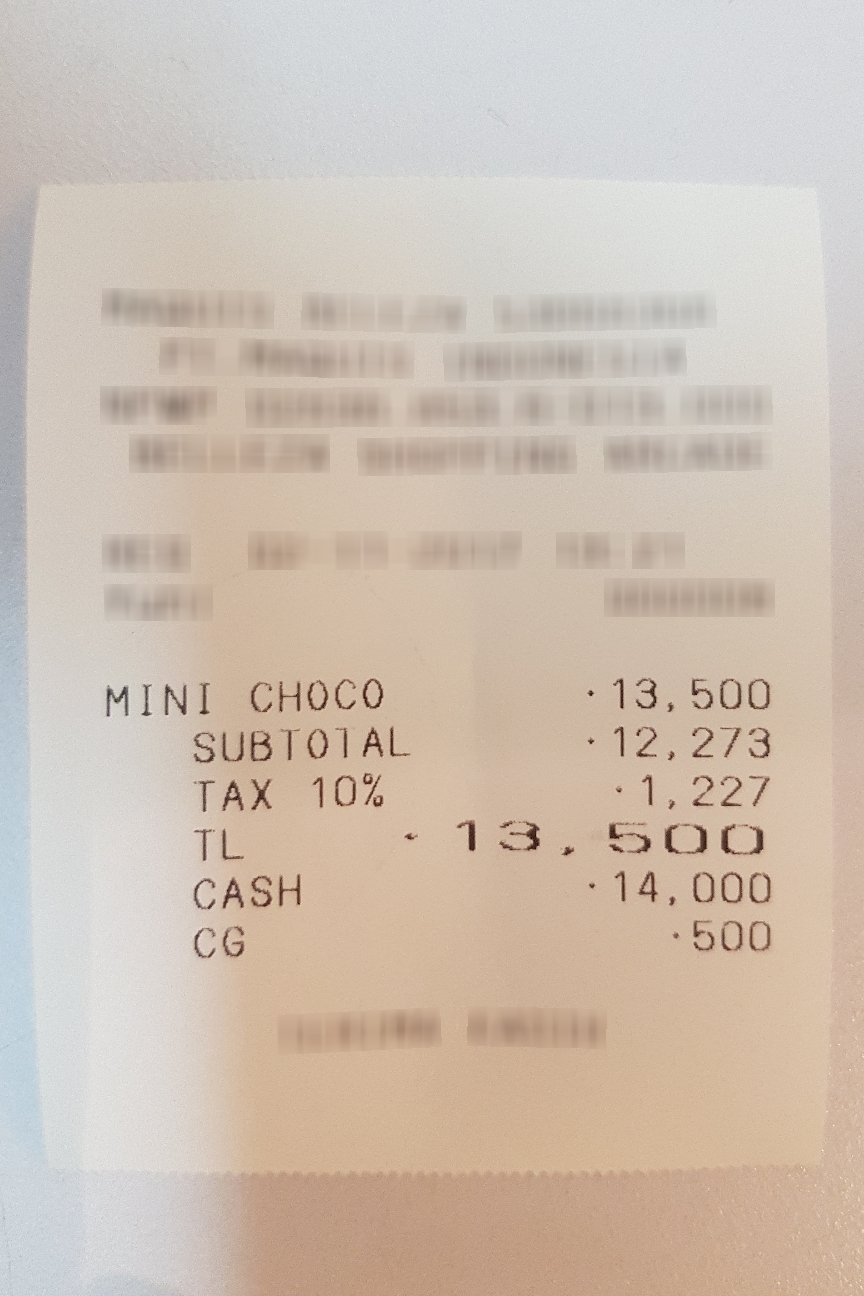

In [298]:
image = Image.open(image_path)#.convert("LA")
image

In [299]:
result = reader.readtext(image_path)
result[1]

([[242, 668], [391, 668], [391, 721], [242, 721]], 'CHoco', 0.2337811022884171)

### Convert to dataset
We create a dummy dataset so we can reuse the tokenize_and_align function and the data_collator.

In [300]:
from datasets import Dataset

from layoutlmft.data.utils import load_image, normalize_bbox

In [301]:
image, size = load_image(image_path)
# tokenize_and_align bugs with 1-example datasets, so we add the parsed data twice.
example = {
    "id": ["0", "1"],
    "bboxes": [[]],
    "tokens": [[]],
    "image": [image, image],
    "ner_tags": [[1]*len(result), [1]*len(result)]
}
for segment in result:
    # skip excerpts with low confidence 
    if segment[2] < 0.1:
        continue
    example["tokens"][0].append(segment[1])
    # bounding box first element is top left corner's x and y, bottom right is the third element.
    bbox = segment[0][0]+segment[0][2]
    example["bboxes"][0].append(normalize_bbox(bbox, size))

example["bboxes"].append(example["bboxes"][0])
example["tokens"].append(example["tokens"][0])

In [302]:
inference_dataset =  Dataset.from_dict(example)
inference_dataset

Dataset({
    features: ['id', 'bboxes', 'tokens', 'image', 'ner_tags'],
    num_rows: 2
})

In [303]:
inference_dataset = inference_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=remove_columns,
    num_proc=1,
    load_from_cache_file=False,
)
inference_dataset

100%|██████████| 1/1 [00:00<00:00,  5.82ba/s]


Dataset({
    features: ['attention_mask', 'bbox', 'image', 'input_ids', 'labels', 'overflow_to_sample_mapping', 'token_type_ids'],
    num_rows: 2
})

We can now use the same code as earlier

In [304]:
with torch.no_grad():
    # we let data_collator take care of the torch conversion
    batch = data_collator([inference_dataset[0]])
    input_ids = batch["input_ids"]
    bbox = batch["bbox"]
    image = batch["image"]
    att_mask = batch["attention_mask"]
    token_type_ids = batch["token_type_ids"]
    #input_ids, bbox, image, attention_mask, token_type_ids, position_ids, head_mask, inputs_embeds, labels, output_attentions, output_hidden_states, return_dict
    y = model(input_ids, bbox, image, att_mask, token_type_ids)

In [315]:
y["logits"][0].argmax(axis=1)[:att_mask.sum().item()]

tensor([34,  5, 34, 34,  7,  7,  7, 19, 44, 44, 44, 44, 44, 44, 20, 45, 45, 45,
        45, 45, 28, 53, 53, 53, 53, 21, 46, 46, 46, 22, 47, 47, 34])

# Older tests

## Pytesseract

In [3]:
import pytesseract
from pytesseract import Output

In [ ]:
custom_oem_psm_config = r"--oem 3 --psm 1 --paragraph_text_based"
data = pytesseract.image_to_data(image, config=custom_oem_psm_config, output_type=Output.DICT)

In [ ]:
import numpy as np

In [47]:
np.array(data["text"])

array(['', '', '', '', 'MINI', 'CHOCO', '', 'SUBTOTAL', '', 'TAX', '10%',
       '', 'TL', '-', '1', '', 'CASH', '', 'CG', '', '', '', '7132.',
       '900', '', 'me.', '273', '', '', '', 'ml', '22/', '', 'SOO', '',
       '', '', '*', '14,000', '', '', '', '-$00'], dtype='<U8')

In [11]:
np.array(data["conf"])

array(['-1', '-1', '-1', '-1', '95'], dtype='<U21')

In [49]:
data.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [47]:
np.array(data["top"])

array([  0,   0,   0,   0,   0, 438, 438, 438, 461, 438, 438, 438, 460,
       459, 458, 456, 452, 448, 594, 594, 594, 609, 607, 604, 594, 636,
       649, 647, 645, 644, 641, 636, 722, 722, 722, 731, 722, 791, 798,
       791, 860, 862, 860, 969, 969, 969, 969,   0,   0,   0,   0])

## Tesserocr
Interfaces directly with the tesseract engine

In [40]:
import tesserocr
print(tesserocr.tesseract_version())  # print tesseract-ocr version
print(tesserocr.get_languages())  # prints tessdata path and list of available languages

tesseract 4.1.1
 leptonica-1.79.0
  libgif 5.1.9 : libjpeg 6b (libjpeg-turbo 2.0.6) : libpng 1.6.37 : libtiff 4.2.0 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.4.0
('/usr/share/tesseract-ocr/4.00/tessdata/', ['eng', 'fra', 'nld', 'osd'])


In [41]:
image = Image.open(image_path)
print(tesserocr.image_to_text(image))

MINI CHOCO
SUBTOTAL
TAX 10%
TL - 1
CASH
CG

7132. 900
me. 273

ml 22/
SOO

* 14,000

-$00



In [42]:
from tesserocr import PyTessBaseAPI, PSM

In [44]:
with PyTessBaseAPI(psm=PSM.SPARSE_TEXT_OSD) as api:
    image = Image.open(image_path)
    api.SetImage(image)
    text = api.GetUTF8Text()
    print(text)

iS. 500

MINI CHOCO

SUBTOI1AL

i. 273

TAX 10%

l22/

Te

+ Le.

SOO

CASH

14,000

CG

-$00



In [45]:
from tesserocr import PyTessBaseAPI, RIL

image = Image.open(image_path)
with PyTessBaseAPI(psm=PSM.AUTO) as api:
    api.SetImage(image)
    boxes = api.GetComponentImages(RIL.TEXTLINE, True)
    print('Found {} textline image components.'.format(len(boxes)))
    for i, (im, box, _, _) in enumerate(boxes):
        # im is a PIL image object
        # box is a dict with x, y, w and h keys
        api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
        ocrResult = api.GetUTF8Text()
        conf = api.MeanTextConf()
        print(u"Box[{0}]: x={x}, y={y}, w={w}, h={h}, "
              "confidence: {1}, text: {2}".format(i, conf, ocrResult, **box))

Found 12 textline image components.
Box[0]: x=24, y=30, w=277, h=37, confidence: 20, text: MINT @EOceo

Box[1]: x=112, y=78, w=216, h=36, confidence: 0, text: 
Box[2]: x=112, y=124, w=189, h=39, confidence: 0, text: 
Box[3]: x=112, y=171, w=380, h=41, confidence: 62, text: Ti + a

Box[4]: x=112, y=225, w=107, h=35, confidence: 0, text: 
Box[5]: x=113, y=277, w=49, h=32, confidence: 0, text: 
Box[6]: x=506, y=29, w=182, h=34, confidence: 0, text: 
Box[7]: x=506, y=78, w=182, h=33, confidence: 0, text: 
Box[8]: x=534, y=126, w=154, h=34, confidence: 0, text: 
Box[9]: x=527, y=174, w=155, h=32, confidence: 0, text: 
Box[10]: x=507, y=222, w=182, h=35, confidence: 0, text: 
Box[11]: x=591, y=271, w=98, h=31, confidence: 0, text: 


In [38]:
pprint(data, compact=True)

{'dontcare': [],
 'meta': {'image_id': 547,
          'image_size': {'height': 1478, 'width': 1108},
          'split': 'train',
          'version': 'v0.1'},
 'repeating_symbol': [[{'quad': {'x1': 181,
                                 'x2': 815,
                                 'x3': 813,
                                 'x4': 182,
                                 'y1': 452,
                                 'y2': 433,
                                 'y3': 457,
                                 'y4': 473},
                        'text': '-'}],
                      [{'quad': {'x1': 179,
                                 'x2': 817,
                                 'x3': 818,
                                 'x4': 177,
                                 'y1': 568,
                                 'y2': 553,
                                 'y3': 585,
                                 'y4': 599},
                        'text': '='}],
                      [{'quad': {'x1': 248,
             

## Test cv2

In [2]:
import cv2

In [23]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [24]:
image = cv2.imread(image_path)
image = get_grayscale(image)
cv2.imshow("img", image)

In [1]:
thresholding(image)

NameError: name 'thresholding' is not defined